<a href="https://colab.research.google.com/github/IrinAnnPaul/Projects_ML/blob/main/Predictive_Modeling_Acetylcholinesterase_Inhibitors/Exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Modeling for Acetylcholinesterase Inhibitors: Exploratory Data Analysis

This notebook performs the Descriptor Calculation using Lipinski's Rule of Five, and Exploratory Data Analysis.

Lipinski's Rule of Five is a guideline for assessing the druglikeness of compounds, particularly their potential for oral bioavailability. The rule is based on key properties that influence how well a drug is absorbed, distributed, metabolized, and excreted (ADME). Christopher Lipinski, a scientist at Pfizer, developed this rule by analyzing FDA-approved orally active drugs. According to Lipinski's Rule, a compound is more likely to be orally active if it meets the following criteria:

Molecular weight is less than 500 Dalton.
Octanol-water partition coefficient (LogP) is less than 5.
Hydrogen bond donors are fewer than 5.
Hydrogen bond acceptors are fewer than 10.
These rules provide a quick way to screen compounds for their potential to become orally available drugs.

The curated Bioactivity data from part 1 is uploaded before running this notebook.

## Installing conda and rdkit

In [4]:
import os
import sys

def run_command(command):
    """Run shell command and suppress output."""
    os.system(command + " > /dev/null 2>&1")

# Remove RDKit environment quietly
run_command('conda remove -n rdkit-env rdkit -y')

# Download the latest Miniconda installer quietly
run_command('wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh')
run_command('chmod +x Miniconda3-latest-Linux-x86_64.sh')
run_command('bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local')

# Create a new environment with Python 3.7 quietly
run_command('conda create -n rdkit-env python=3.7 -y')

# Install RDKit quietly
run_command('conda install -n rdkit-env -c conda-forge rdkit=2022.09.1 -y')

import sys
sys.path.append('/usr/local/envs/rdkit-env/lib/python3.7/site-packages/')


In [5]:
# importing libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

## Load bioactivity data

In [6]:
# drop rows with missing values in canonical smiles, std value or class
df = pd.read_csv('acetylcholinesterase_03_bioactivity_data_curated.csv')
df = df[df.standard_value.notna()]
df = df[df.canonical_smiles.notna()]
df.dropna(subset=['class'], inplace=True)
df


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
4158,CHEMBL4077169,CN1c2ccccc2C(N2CCOCC2)c2ccccc21,12300.0,active
4159,CHEMBL4065259,CN1c2ccccc2C(N2CCSCC2)c2ccccc21,11800.0,intermediate
4160,CHEMBL4075825,CN1c2ccccc2C(n2cncn2)c2ccccc21,18800.0,inactive
4161,CHEMBL4075624,CN1c2ccccc2C(n2cnc([N+](=O)[O-])n2)c2ccccc21,16700.0,inactive


The following code block cleans up the SMILES notation by keeping only the longest molecular fragment in cases where multiple molecules are present in a single SMILES string (separated by periods). It then reconstructs the DataFrame with the cleaned SMILES data and other columns intact.

In [7]:
df_no_smiles = df.drop(columns='canonical_smiles')

smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
4158,CHEMBL4077169,12300.0,active,CN1c2ccccc2C(N2CCOCC2)c2ccccc21
4159,CHEMBL4065259,11800.0,intermediate,CN1c2ccccc2C(N2CCSCC2)c2ccccc21
4160,CHEMBL4075825,18800.0,inactive,CN1c2ccccc2C(n2cncn2)c2ccccc21
4161,CHEMBL4075624,16700.0,inactive,CN1c2ccccc2C(n2cnc([N+](=O)[O-])n2)c2ccccc21


## Calculate Lipinski descriptors

In [8]:
# function to calculate descriptors
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [9]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
4158,280.371,3.1895,0.0,3.0
4159,296.439,3.9061,0.0,3.0
4160,262.316,2.9971,0.0,4.0
4161,307.313,2.9053,0.0,6.0


## Combine DataFrames
Combining the initial dataframe with the one after descriptor calculation

In [10]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.3574,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.7069,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
4158,CHEMBL4077169,CN1c2ccccc2C(N2CCOCC2)c2ccccc21,12300.0,active,280.371,3.1895,0.0,3.0
4159,CHEMBL4065259,CN1c2ccccc2C(N2CCSCC2)c2ccccc21,11800.0,intermediate,296.439,3.9061,0.0,3.0
4160,CHEMBL4075825,CN1c2ccccc2C(n2cncn2)c2ccccc21,18800.0,inactive,262.316,2.9971,0.0,4.0
4161,CHEMBL4075624,CN1c2ccccc2C(n2cnc([N+](=O)[O-])n2)c2ccccc21,16700.0,inactive,307.313,2.9053,0.0,6.0


## Convert IC50 to pIC50
To ensure a more uniform distribution of IC50 data, we will convert the IC50 values to a negative logarithmic scale using the formula -log10(IC50).

The custom function pIC50() will take a DataFrame as input and perform the following steps:

Extract the IC50 values from the standard_value column and convert them from nanomolar (nM) to molar (M) by multiplying by 10^(−9)

Apply the transformation -log10 to the molar values.
Remove the standard_value column and create a new column named pIC50 to store the transformed values.

In [11]:
def pIC50(input):
    pIC50_values = []

    for i in input['standard_value_norm']:
        molar = i * (10**-9)  # Converts nM to M

        # Check if molar is greater than zero to avoid division by zero
        if molar > 0:
            pIC50_values.append(-np.log10(molar))
        else:
            pIC50_values.append(np.nan)  # or choose a different way to handle it

    input['pIC50'] = pIC50_values
    x = input.drop('standard_value_norm', axis=1)  # Use axis=1 to drop a column

    return x

In [12]:
df_combined.standard_value.describe()

,standard_value
count,4.163000e+03
mean,1.246980e+05
std,1.088561e+06
min,6.000000e-03
25%,1.200000e+02
50%,2.150000e+03
75%,1.803000e+04
max,4.960000e+07


### Normalizing the values in 'standard_value' column

In [13]:
def norm_value(input):
    # Cap the values
    input['standard_value'] = input['standard_value'].where(input['standard_value'] <= 100000000, 100000000)

    # Min-Max normalization
    min_val = input['standard_value'].min()
    max_val = input['standard_value'].max()
    input['standard_value_norm'] = (input['standard_value'] - min_val) / (max_val - min_val)

    # Drop the original column
    x = input.drop('standard_value', axis=1)

    return x

In [14]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,0.000015
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,0.000002
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,0.001008
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,0.000006
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,0.000016
...,...,...,...,...,...,...,...,...
4158,CHEMBL4077169,CN1c2ccccc2C(N2CCOCC2)c2ccccc21,active,280.371,3.1895,0.0,3.0,0.000248
4159,CHEMBL4065259,CN1c2ccccc2C(N2CCSCC2)c2ccccc21,intermediate,296.439,3.9061,0.0,3.0,0.000238
4160,CHEMBL4075825,CN1c2ccccc2C(n2cncn2)c2ccccc21,inactive,262.316,2.9971,0.0,4.0,0.000379
4161,CHEMBL4075624,CN1c2ccccc2C(n2cnc([N+](=O)[O-])n2)c2ccccc21,inactive,307.313,2.9053,0.0,6.0,0.000337


In [15]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,4163.000000
mean,0.002514
std,0.021947
min,0.000000
25%,0.000002
50%,0.000043
75%,0.000364
max,1.000000


In [16]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,13.820424
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,14.695508
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,11.996512
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,14.218369
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,13.792395
...,...,...,...,...,...,...,...,...
4158,CHEMBL4077169,CN1c2ccccc2C(N2CCOCC2)c2ccccc21,active,280.371,3.1895,0.0,3.0,12.605577
4159,CHEMBL4065259,CN1c2ccccc2C(N2CCSCC2)c2ccccc21,intermediate,296.439,3.9061,0.0,3.0,12.623600
4160,CHEMBL4075825,CN1c2ccccc2C(n2cncn2)c2ccccc21,inactive,262.316,2.9971,0.0,4.0,12.421324
4161,CHEMBL4075624,CN1c2ccccc2C(n2cnc([N+](=O)[O-])n2)c2ccccc21,inactive,307.313,2.9053,0.0,6.0,12.472765


In [17]:
df_final.pIC50.describe()

,pIC50
count,4162.000000
mean,13.520910
std,1.541136
min,9.000000
25%,12.439125
50%,13.362037
75%,14.616322
max,19.394452


In [18]:
# writing to csv file
df_final.to_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

## Removing 'Intermediate' class

In [19]:
df_2class = df_final[df_final['class'] != 'intermediate']
# writing to csv file
df_2class.to_csv('acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv')

df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,13.820424
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,14.695508
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,11.996512
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,14.218369
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,13.792395
...,...,...,...,...,...,...,...,...
4157,CHEMBL4070092,C[n+]1c2ccccc2c(-c2cccs2)c2ccccc21.F[B-](F)(F)F,active,276.384,4.5460,0.0,1.0,12.083758
4158,CHEMBL4077169,CN1c2ccccc2C(N2CCOCC2)c2ccccc21,active,280.371,3.1895,0.0,3.0,12.605577
4160,CHEMBL4075825,CN1c2ccccc2C(n2cncn2)c2ccccc21,inactive,262.316,2.9971,0.0,4.0,12.421324
4161,CHEMBL4075624,CN1c2ccccc2C(n2cnc([N+](=O)[O-])n2)c2ccccc21,inactive,307.313,2.9053,0.0,6.0,12.472765


## EXploratory Data Analysis

### Frequency plot for the Bioactivity classes

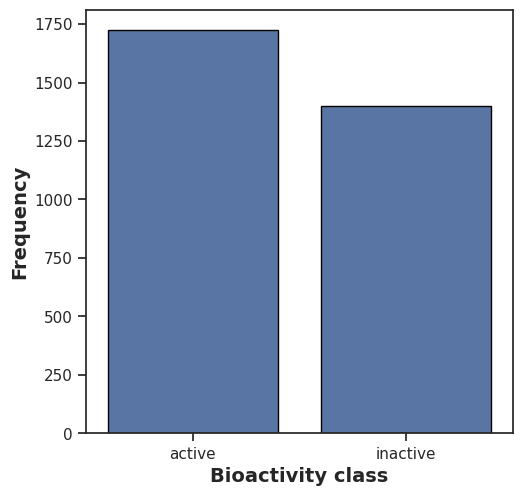

In [20]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatterplot of MV vs LogP


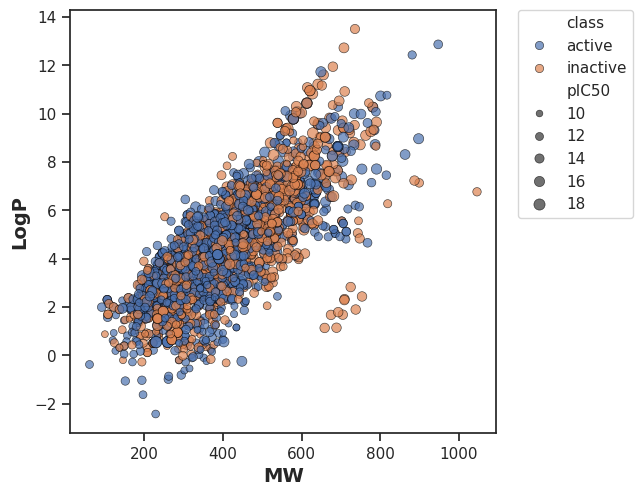

In [21]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

As seen from the scatterplot, the 2 bioactiivty classes span the same chemical space

## Analysing the Lipinsky Descriptors

In [22]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

### pIC50 value

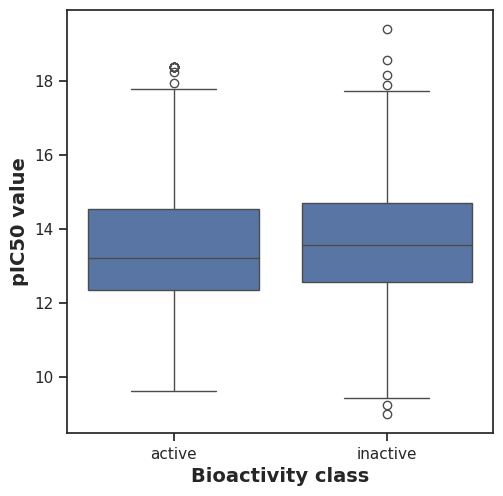

In [23]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [24]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1125219.5,0.001163,0.05,Different distribution (reject H0)


### Molecular Weight

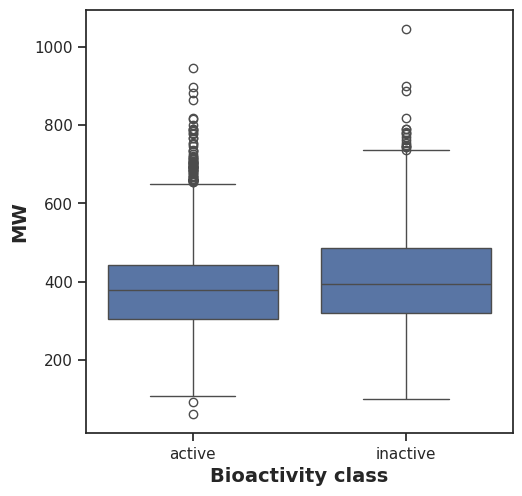

In [25]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [26]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1090710.5,0.000004,0.05,Different distribution (reject H0)


### LogP value

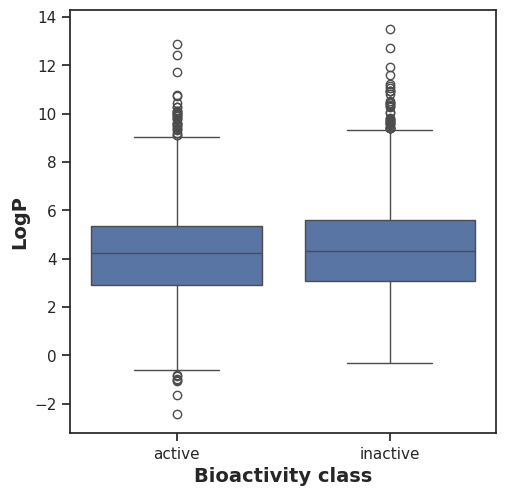

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [28]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1142821.5,0.010909,0.05,Different distribution (reject H0)


### NumHDonors

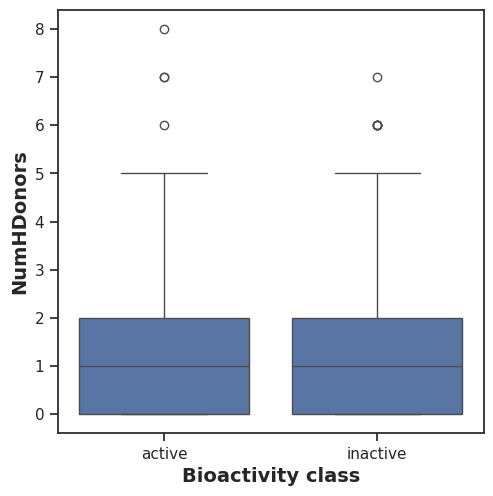

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [30]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1140014.0,0.005161,0.05,Different distribution (reject H0)


### NumHAcceptors

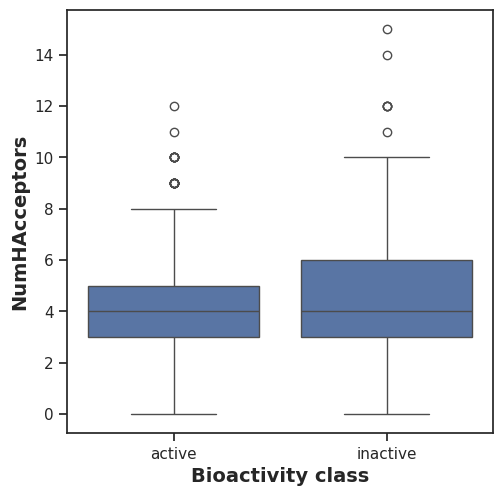

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [32]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1150230.0,0.022201,0.05,Different distribution (reject H0)


## Interpretation

The comparison of Lipinsky descritors 'Active' and 'Inactive' bioactiivty classes show statistically significant differences

## Saving all the generated files as zip file

In [33]:
! zip -r results.zip . -i *.csv *.pdf

updating: plot_MW.pdf (deflated 37%)
updating: acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv (deflated 75%)
updating: plot_MW_vs_LogP.pdf (deflated 2%)
updating: plot_NumHDonors.pdf (deflated 38%)
updating: plot_LogP.pdf (deflated 37%)
updating: mannwhitneyu_pIC50.csv (deflated 10%)
updating: plot_bioactivity_class.pdf (deflated 39%)
updating: plot_NumHAcceptors.pdf (deflated 38%)
updating: plot_ic50.pdf (deflated 38%)
updating: acetylcholinesterase_03_bioactivity_data_curated.csv (deflated 82%)
updating: mannwhitneyu_NumHDonors.csv (deflated 11%)
updating: mannwhitneyu_MW.csv (deflated 9%)
updating: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
  adding: acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv (deflated 75%)
  adding: mannwhitneyu_LogP.csv (deflated 9%)
